Create a raster where aspect is classified into North and South facing slopes

In [1]:
import gdal

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
aspect_file_path = r"/Users/AuerPower/Documents/RSDI-2018/data/Day2_LiDAR_Intro/NEON_D17_TEAK_DP3_316000_4106000_aspect.tif"

In [4]:
aspect_file = gdal.Open(aspect_file_path)

In [5]:
# %load /Users/AuerPower/Documents/RSDI-2018/neon_aop_lidar_python_functions/raster2array
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = float(dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']))
            band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

In [6]:
[aspect_array, aspect_metadata] = raster2array(aspect_file_path)
aspect_array

array([[312.73199463, 309.72000122, 303.12200928, ..., 315.86898804,
        316.02200317, 315.37600708],
       [309.51599121, 304.07299805, 297.54699707, ..., 321.86401367,
        320.83599854, 319.21099854],
       [312.26199341, 304.61801147, 296.69900513, ..., 318.24499512,
        317.53900146, 318.33499146],
       ...,
       [153.54600525, 157.52999878, 160.07400513, ..., 160.72399902,
        147.32299805, 131.44400024],
       [152.43099976, 156.16099548, 157.72900391, ..., 161.2769928 ,
        149.21200562, 120.34300232],
       [152.14599609, 154.82299805, 155.26800537, ..., 169.02799988,
        165.85299683, 124.86000061]])

In [7]:
dir_class = aspect_array.copy()
dir_class

array([[312.73199463, 309.72000122, 303.12200928, ..., 315.86898804,
        316.02200317, 315.37600708],
       [309.51599121, 304.07299805, 297.54699707, ..., 321.86401367,
        320.83599854, 319.21099854],
       [312.26199341, 304.61801147, 296.69900513, ..., 318.24499512,
        317.53900146, 318.33499146],
       ...,
       [153.54600525, 157.52999878, 160.07400513, ..., 160.72399902,
        147.32299805, 131.44400024],
       [152.43099976, 156.16099548, 157.72900391, ..., 161.2769928 ,
        149.21200562, 120.34300232],
       [152.14599609, 154.82299805, 155.26800537, ..., 169.02799988,
        165.85299683, 124.86000061]])

In [8]:
dir_class[np.where((aspect_array>0) & (aspect_array<45))] = 1 # north
dir_class[np.where((aspect_array>315) & (aspect_array<360))] = 1 # north
dir_class[np.where((aspect_array>135) & (aspect_array<225))] = 2 # south

/Users/AuerPower/anaconda3/envs/p35/lib/python3.5/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


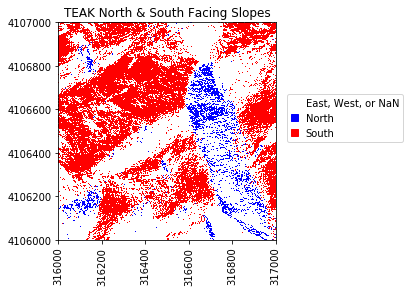

In [11]:
# Plot classified aspect (N-S) array
from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['white','blue','red'])
plt.imshow(dir_class,extent=aspect_metadata['extent'],cmap=cmapNS)
plt.title('TEAK North & South Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label N & S
import matplotlib.patches as mpatches
white_box = mpatches.Patch(color='white',edgecolor='red',label='East, West, or NaN')
blue_box = mpatches.Patch(color='blue', label='North')
red_box = mpatches.Patch(color='red', label='South')
ax.legend(handles=[white_box,blue_box,red_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.45), 
          loc='lower left', borderaxespad=0.)